In [1]:
%load_ext watermark
%watermark -p torch,lightning,torchvision

torch      : 2.7.0+cu128
lightning  : 2.5.2
torchvision: 0.22.0+cu128



In [2]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel,Cifar10DataModule,plot_loss_and_acc

In [3]:
import torch

entrypoints = torch.hub.list('pytorch/vision',force_reload=True)
for e in entrypoints:
    if "resnet" in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/zeus/.cache/torch/hub/main.zip
deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


In [4]:
%%capture --no-display
L.pytorch.seed_everything(123)

repo = "pytorch/vision"
pytorch_model = torch.hub.load(repo, "resnet18", weights="IMAGENET1K_V1")


Seed set to 123


In [5]:
# Also

# from torchvision.models import resnet18, ResNet18_Weights
# weights = ResNet18_Weights.IMAGENET1K_V1

In [6]:
pytorch_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
# Training the last layer

for param in pytorch_model.parameters():
    param.requires_grad = False

pytorch_model.fc = torch.nn.Linear(512, 10)

In [8]:
# it is good to apply similar data transformations used for pretraining training


from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
L.pytorch.seed_everything(123)

dm = Cifar10DataModule(
    batch_size=64, 
    num_workers=4,
    train_transform=preprocess_transform,
    test_transform=preprocess_transform
)
dm.prepare_data()
dm.setup()

Seed set to 123
100%|██████████| 170M/170M [00:01<00:00, 94.3MB/s] 


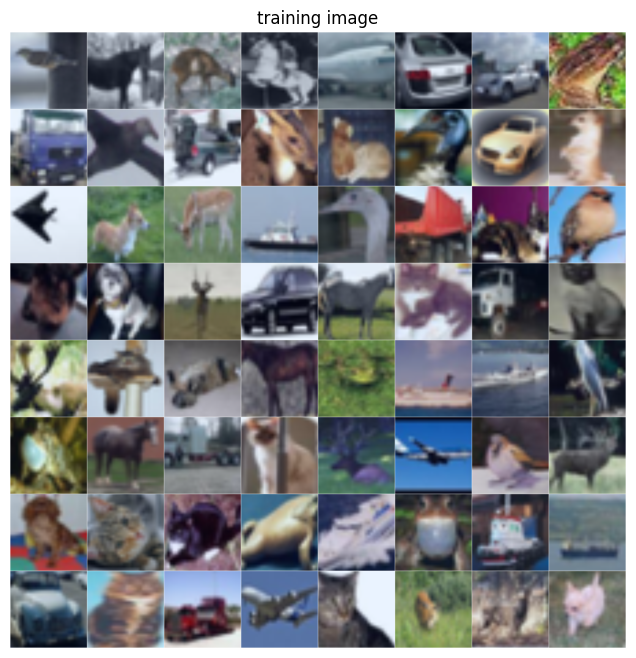

In [11]:
for images, labels in dm.train_dataloader():
    break

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("training image")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            images[:64],
            padding=1,
            pad_value=1.0,
            normalize=True
        ),
        (1,2,0)
    )
)
plt.show()

In [12]:
images[0].shape

torch.Size([3, 224, 224])

In [ ]:
L.pytorch.seed_everything(123)

dm = Cifar10DataModule(
    height_width=(224,224)
    batch_size=64, 
    num_workers=4,
    train_transform=preprocess_transform,
    test_transform=preprocess_transform
)

l_model = LightningModel(model=pytorch_model, learning_rate=0.1, num_classes=10)

trainer= L.Trainer(
    # fast_dev_run=1,
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    logger=CSVLogger(save_dir='logs/', name='cifr-resnet18-last-layer'),
    deterministic=True
)

In [ ]:
trainer.fit(model=l_model, datamodule=dm)

In [ ]:
plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
trainer.test(model=l_model, datamodule=dm)